参考：https://github.com/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_5_階層ベイズモデル.ipynb

pymc3ではnumpyroを使えず、最新のpymcをインストールする必要があった。

pymc用の仮想環境を作成した

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

sns.set_context('talk', font_scale=0.8)

データの作成

外気温：　t_out ~ N(mu_0, sigma_0); mu_0=20, sigma_0=7

内温max：　t_in_h ~ N(t_out * a_1 + b_1, sigma_1); a_1=0.3, b_1=60, sigma_1=1

品質指標：　q ~ N(t_in_h * a_2 + b_2, sigma_2); a_2=1, b_2=0, sigma_2=2

In [24]:
np.random.seed(12)
group_num = 9
data_num = 100

t_out = np.random.normal(20, 7, size=data_num)
t_in_h = 0.3*t_out + 60 + np.random.normal(0, 1, size=data_num)
q = 1*t_in_h + 0 + np.random.normal(0, 2, size=data_num)

df_data = pd.DataFrame([t_out, q]).T
df_data.columns = ['t_out', 'q']
df_data

,t_out,q
0,23.310901,66.642676
1,15.230019,62.137820
2,21.697076,68.106643
3,8.094851,60.679602
4,25.272000,69.949737
...,...,...
95,13.215765,63.531645
96,26.103777,65.984319
97,9.875484,64.023259
98,16.244631,66.589360


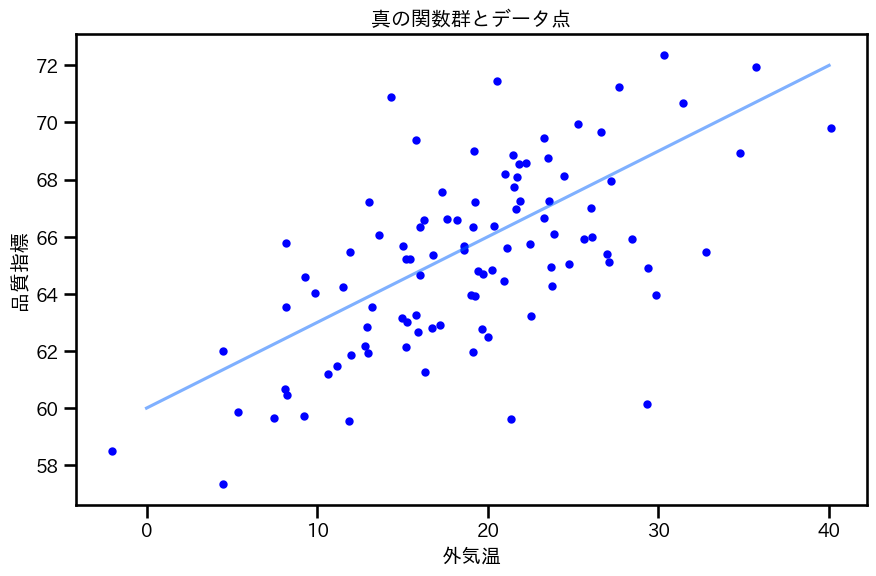

In [28]:
# 説明変数
x_data = df_data['t_out'].values
# 目的変数
y_data = df_data['q'].values

# 可視化用
x_linspace = np.linspace(0, 40, 100)

fig, ax = plt.subplots(figsize=(9, 6))
cm10 = plt.get_cmap('jet', 10)

# 真の関数可視化
ax.plot(x_linspace, (x_linspace*0.3+60)*1+0, color=cm10(2), alpha=0.5)
# 学習データ可視化
ax.scatter(x_data, y_data, marker='.', color=cm10(1))

ax.set_xlabel('外気温');ax.set_ylabel('品質指標')
ax.set_title('真の関数群とデータ点')
plt.tight_layout()

階層ベイズモデル

In [30]:
import pymc as pm

# モデルの定義
with pm.Model() as model:

    # 説明変数
    X_shared = pm.Data("x", x_data)

    # 傾きについてのハイパーパラメータの事前分布
    a_1_mu = pm.Normal('a_1_mu', mu=10.0, sigma=10.0)
    a_1_sigma = pm.HalfCauchy('a_1_sigma', beta=100.0)
    b_1_mu = pm.Normal('b_1_mu', mu=10.0, sigma=10.0)
    b_1_sigma = pm.HalfCauchy('b_1_sigma', beta=100.0)

    a_1 = pm.Normal('a_1', mu=a_1_mu, sigma=a_1_sigma)
    b_1 = pm.Normal('b_1', mu=b_1_mu, sigma=b_1_sigma)
    sigma_1 = pm.HalfCauchy('sigma_1', beta=1000.0)

    t_in_h_ = pm.Normal('t_in_h', mu=X_shared*a_1 + b_1, sigma=sigma_1)

    a_2_mu = pm.Normal('a_2_mu', mu=1.0, sigma=10.0)
    a_2_sigma = pm.HalfCauchy('a_2_sigma', beta=100.0)
    b_2_mu = pm.Normal('b_2_mu', mu=1.0, sigma=10.0)
    b_2_sigma = pm.HalfCauchy('b_2_sigma', beta=100.0)

    a_2 = pm.Normal('a_2', mu=a_2_mu, sigma=a_2_sigma)
    b_2 = pm.Normal('b_2', mu=b_2_mu, sigma=b_2_sigma)

    y = pm.Normal('y', mu=t_in_h_*a_2 + b_2, sigma=3, observed=y_data)



/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [31]:
with model:
    # MCMCによる推論
    trace = pm.sample(
                    draws=3000, 
                    tune=1000, 
                    nuts_sampler="numpyro",
                    chains=3, 
                    random_seed=1, 
                    return_inferencedata=True)

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:03.145166
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

Running chain 0:   0%|          | 0/4000 [00:02<?, ?it/s]

Running chain 0:  90%|█████████ | 3600/4000 [00:08<00:00, 422.35it/s]

Running chain 2: 100%|██████████| 4000/4000 [00:09<00:00, 411.89it/s]

Sampling time =  0:00:10.088233
Transforming variables...
Transformation time =  0:00:00.014985


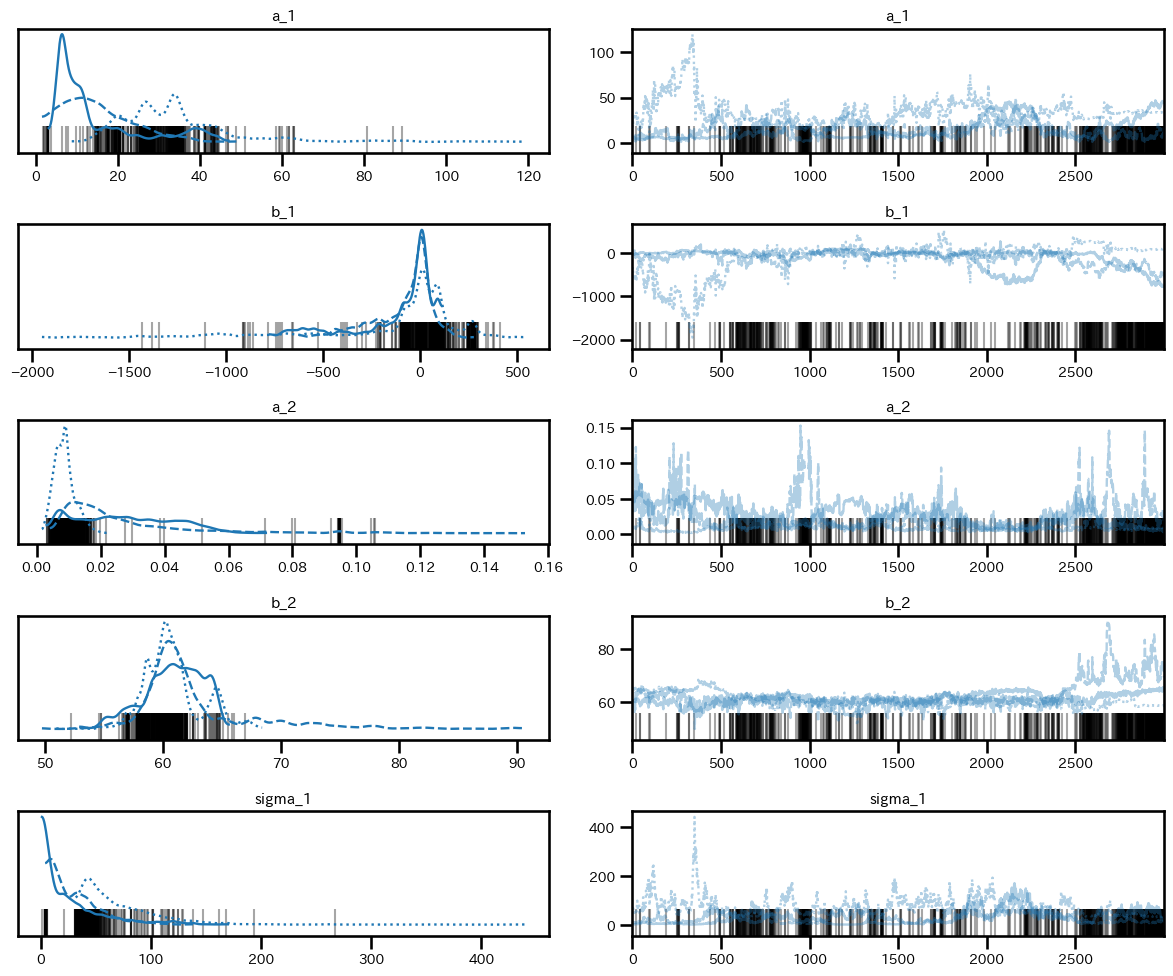

In [32]:
az.plot_trace(trace, var_names=['a_1', 'b_1', 'a_2', 'b_2', 'sigma_1']);
plt.tight_layout();
     

In [9]:

for var_info in az.rhat(trace).values():
  print(var_info.name, var_info.values.round(3))

a_mu 1.007
a_offset [1.002 1.003 1.001 1.004 1.007 1.007 1.007 1.002 1.002]
b_mu 1.007
b_offset [1.006 1.004 1.001 1.004 1.005 1.003 1.01  1.002 1.002]
a_sigma 1.001
b_sigma 1.03


In [10]:
trace.posterior['a_offset'].shape

(3, 3000, 9)

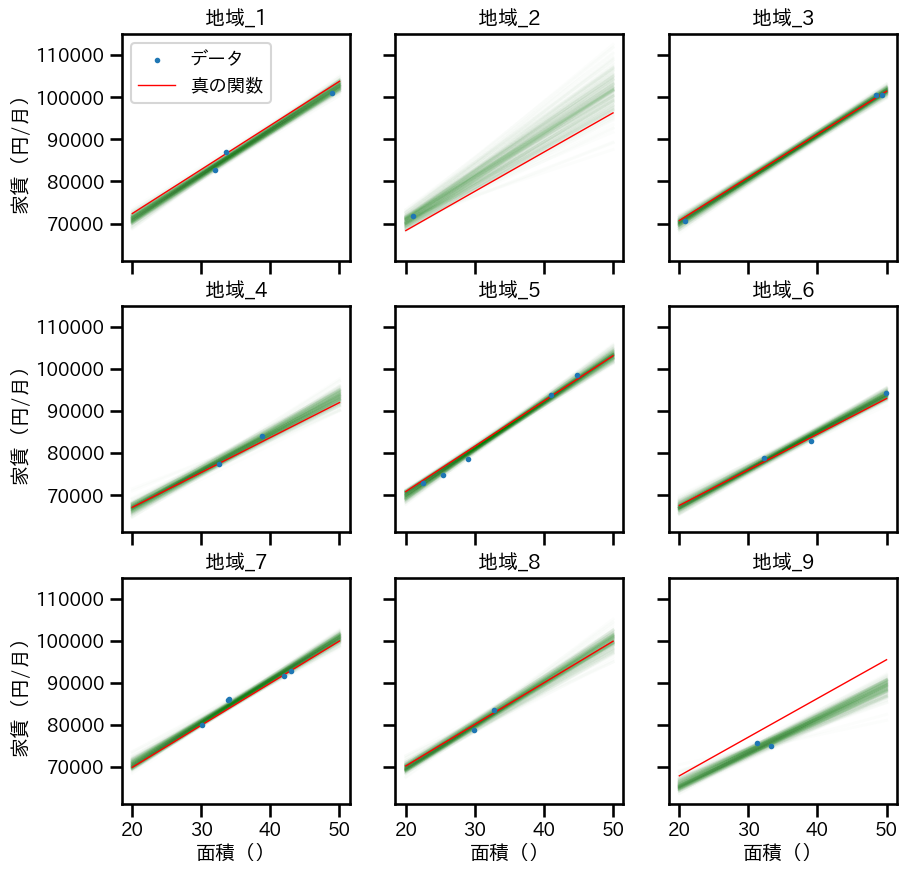

In [11]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, sharex=True, sharey=True)
x_new = np.linspace(20, 50, 100)

# 地域グループ毎に処理
for i in range(9):
  row_index = i//3
  col_index  = i%3

  # 地域ごとの係数パラメータのMCMCサンプル平均値と標準偏差を算出
  a_i_mcmc_samples = trace.posterior['a_offset'][0, :, i]
  b_i_mcmc_samples = trace.posterior['b_offset'][0, :, i]
  
  # 学習データ可視化
  x_i = x_data[group_idx==i]
  y_i = y_data[group_idx==i]
  ax[row_index, col_index].scatter(x_i, y_i, marker='.', zorder=3, s=25, label='データ')
  
  # MCMCサンプルを使って予測分布の平均を可視化
  for k in range(0, 3000, 15):
    y_new_sample = a_i_mcmc_samples[k].values * x_new + b_i_mcmc_samples[k].values
    ax[row_index, col_index].plot(x_new, y_new_sample, alpha=0.01, color ='green', zorder=1)
    
  # 真の関数可視化
  y_true = a_vector[i]*x_new+b_vector[i]
  ax[row_index, col_index].plot(x_new, y_true, color = 'red',\
  linewidth = 1, label='真の関数')
  
  ax[row_index, col_index].set_title('地域_{}'.format(i+1))
  if row_index==2:
    ax[row_index, col_index].set_xlabel('面積（）')
  if col_index==0:
    ax[row_index, col_index].set_ylabel('家賃（円/月）')
ax[0, 0].legend();